# Telco Customer Churn Analysis

### Created by : Rivaldo Nugradwiyanto

## Business Problem

**Background**  
A telecommunication company wants to identify who likely to churn. Churn occurs when customer not longer using the company's services. It is a major issue because it can reduce revenue and harm company's reputation. Churned customer also can share negative feedback that can influence other potentioal customers. Common reasons for customers to churn usually when the costs don't match the value received, while customers with lower-cost plans tend to stay longer.

Target:  
0 : No Churn 
1 : Churn

**Problem Statement**  
How can we identify customer who likely to churn based on their characteristic and behaviour, so that company can take preventive action to reduce churn.

**Goals**  
Based on this problem, the goal of this project is to build a machine learning model to identify customers who likely to churn and also identify key factors that affects customers on deciding whether to stay or churn, so that the model can help company to create effective retention strategies.

**Analytic Approach**
The analysis starts with Exploratory Data Analysis (EDA) to understand customer patterns and characteristics related to churn. After that, a classification model is developed to predict whether a customer will churn based on available features.

**Evaluation Metrics**

| Actual/Prediction | No Churn | Churn |
| --- | --- | --- |
| No Churn | TN | FP |
| Churn | FN | TP |

Because churn data often has class imbalance, accuracy is not used as the main metric. Recall is prioritized to minimize false negatives (missed churners), which can lead to revenue loss. Precision is considered to avoid excessive retention actions, and F1-score is used to balance precision and recall.


## Data Understanding

In [1]:
# Library

import pandas as pd
import numpy as np

# Visualization
import matplotlib.pyplot as plt
import seaborn as sns
import missingno as msno
from IPython.display import display

# Feature Engineering
from sklearn.pipeline import Pipeline
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import OneHotEncoder, LabelEncoder, OrdinalEncoder, StandardScaler
from sklearn.compose import ColumnTransformer
import category_encoders as ce

# Model Selection
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import GridSearchCV,StratifiedKFold,train_test_split, cross_val_score
from sklearn.metrics import classification_report, confusion_matrix
from sklearn.ensemble import RandomForestClassifier
from xgboost import XGBClassifier
import lightgbm as lgb
from sklearn.metrics import f1_score, accuracy_score, recall_score, precision_score
from sklearn.metrics import roc_auc_score

# Imbalance Dataset
from imblearn.pipeline import Pipeline

# Ignore Warning
import sys
import warnings
if not sys.warnoptions:
    warnings.simplefilter("ignore")

# Set max columns
pd.set_option('display.max_columns', None)

### Attribute Information

| Attribute        | Data Type | Description                                               |
| ---------------- | --------- | --------------------------------------------------------- |
| Dependents       | object    | Whether the customer has dependents or not                |
| tenure           | int       | Total number of months the customer has been subscribed   |
| OnlineSecurity   | object    | Whether the customer has online security service or not   |
| OnlineBackup     | object    | Whether the customer has online backup service or not     |
| InternetService  | object    | Type of internet service used by the customer             |
| DeviceProtection | object    | Whether the customer has device protection service or not |
| TechSupport      | object    | Whether the customer has tech support service or not      |
| Contract         | object    | Type of contract based on duration                        |
| PaperlessBilling | object    | Whether the customer uses paperless billing or not        |
| MonthlyCharges   | float     | Total monthly subscription cost                           |
| Churn            | object    | Whether the customer stopped subscribing or not           |


In [2]:
df = pd.read_csv('data_telco_customer_churn.csv')

In [3]:
df.head()

,Dependents,tenure,OnlineSecurity,OnlineBackup,InternetService,DeviceProtection,TechSupport,Contract,PaperlessBilling,MonthlyCharges,Churn
0,Yes,9,No,No,DSL,Yes,Yes,Month-to-month,Yes,72.90,Yes
1,No,14,No,Yes,Fiber optic,Yes,No,Month-to-month,Yes,82.65,No
2,No,64,Yes,No,DSL,Yes,Yes,Two year,No,47.85,Yes
3,No,72,Yes,Yes,DSL,Yes,Yes,Two year,No,69.65,No
4,No,3,No internet service,No internet service,No,No internet service,No internet service,Month-to-month,Yes,23.60,No


In [4]:
df.shape

(4930, 11)

In [5]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 4930 entries, 0 to 4929
Data columns (total 11 columns):
 #   Column            Non-Null Count  Dtype  
---  ------            --------------  -----  
 0   Dependents        4930 non-null   object 
 1   tenure            4930 non-null   int64  
 2   OnlineSecurity    4930 non-null   object 
 3   OnlineBackup      4930 non-null   object 
 4   InternetService   4930 non-null   object 
 5   DeviceProtection  4930 non-null   object 
 6   TechSupport       4930 non-null   object 
 7   Contract          4930 non-null   object 
 8   PaperlessBilling  4930 non-null   object 
 9   MonthlyCharges    4930 non-null   float64
 10  Churn             4930 non-null   object 
dtypes: float64(1), int64(1), object(9)
memory usage: 423.8+ KB


The dataset contains 4,930 rows representing telecom customers, with 11 columns covering customer demographics, services used, contract details, and monthly charges.

In [6]:
df['InternetService'].value_counts()

InternetService
Fiber optic    2172
DSL            1706
No             1052
Name: count, dtype: int64

In [7]:
listItem = []
for col in df.columns :
    listItem.append([col, df[col].dtype, df[col].isna().sum(), round((df[col].isna().sum()/len(df[col])) * 100,2),
                    df[col].nunique(), list(df[col].drop_duplicates().sample(2).values)]);

dfDesc = pd.DataFrame(columns=['dataFeatures', 'dataType', 'null', 'nullPct', 'unique', 'uniqueSample'],
                     data=listItem)
dfDesc

,dataFeatures,dataType,null,nullPct,unique,uniqueSample
0,Dependents,object,0,0.0,2,"[No, Yes]"
1,tenure,int64,0,0.0,73,"[69, 22]"
2,OnlineSecurity,object,0,0.0,3,"[Yes, No]"
3,OnlineBackup,object,0,0.0,3,"[No internet service, Yes]"
4,InternetService,object,0,0.0,3,"[No, DSL]"
5,DeviceProtection,object,0,0.0,3,"[No, Yes]"
6,TechSupport,object,0,0.0,3,"[No internet service, No]"
7,Contract,object,0,0.0,3,"[Two year, Month-to-month]"
8,PaperlessBilling,object,0,0.0,2,"[No, Yes]"
9,MonthlyCharges,float64,0,0.0,1422,"[100.55, 93.3]"


Based on the observation of unique values in the dataset, there are no typos or inconsistent category labels. All values can be considered valid.

In [8]:
df[df.duplicated]

,Dependents,tenure,OnlineSecurity,OnlineBackup,InternetService,DeviceProtection,TechSupport,Contract,PaperlessBilling,MonthlyCharges,Churn
624,No,1,No internet service,No internet service,No,No internet service,No internet service,Month-to-month,No,19.65,No
701,No,41,No internet service,No internet service,No,No internet service,No internet service,Two year,No,20.65,No
786,No,1,No,No,Fiber optic,No,No,Month-to-month,Yes,69.65,Yes
951,No,1,No internet service,No internet service,No,No internet service,No internet service,Month-to-month,No,20.15,Yes
1266,No,1,No internet service,No internet service,No,No internet service,No internet service,Month-to-month,No,19.65,No
...,...,...,...,...,...,...,...,...,...,...,...
4759,No,4,No internet service,No internet service,No,No internet service,No internet service,Month-to-month,No,20.05,No
4786,No,1,No internet service,No internet service,No,No internet service,No internet service,Month-to-month,No,20.35,No
4788,No,1,No,No,Fiber optic,No,No,Month-to-month,Yes,70.10,Yes
4866,No,1,No,No,DSL,No,No,Month-to-month,Yes,55.00,Yes


It can be seen that there are a total of 77 duplicate rows. However, since the dataset doesn't include a unique identifier such as CustomerID, these rows are assumed to represent different customers who happen to have similar characteristics or services.


<Axes: >

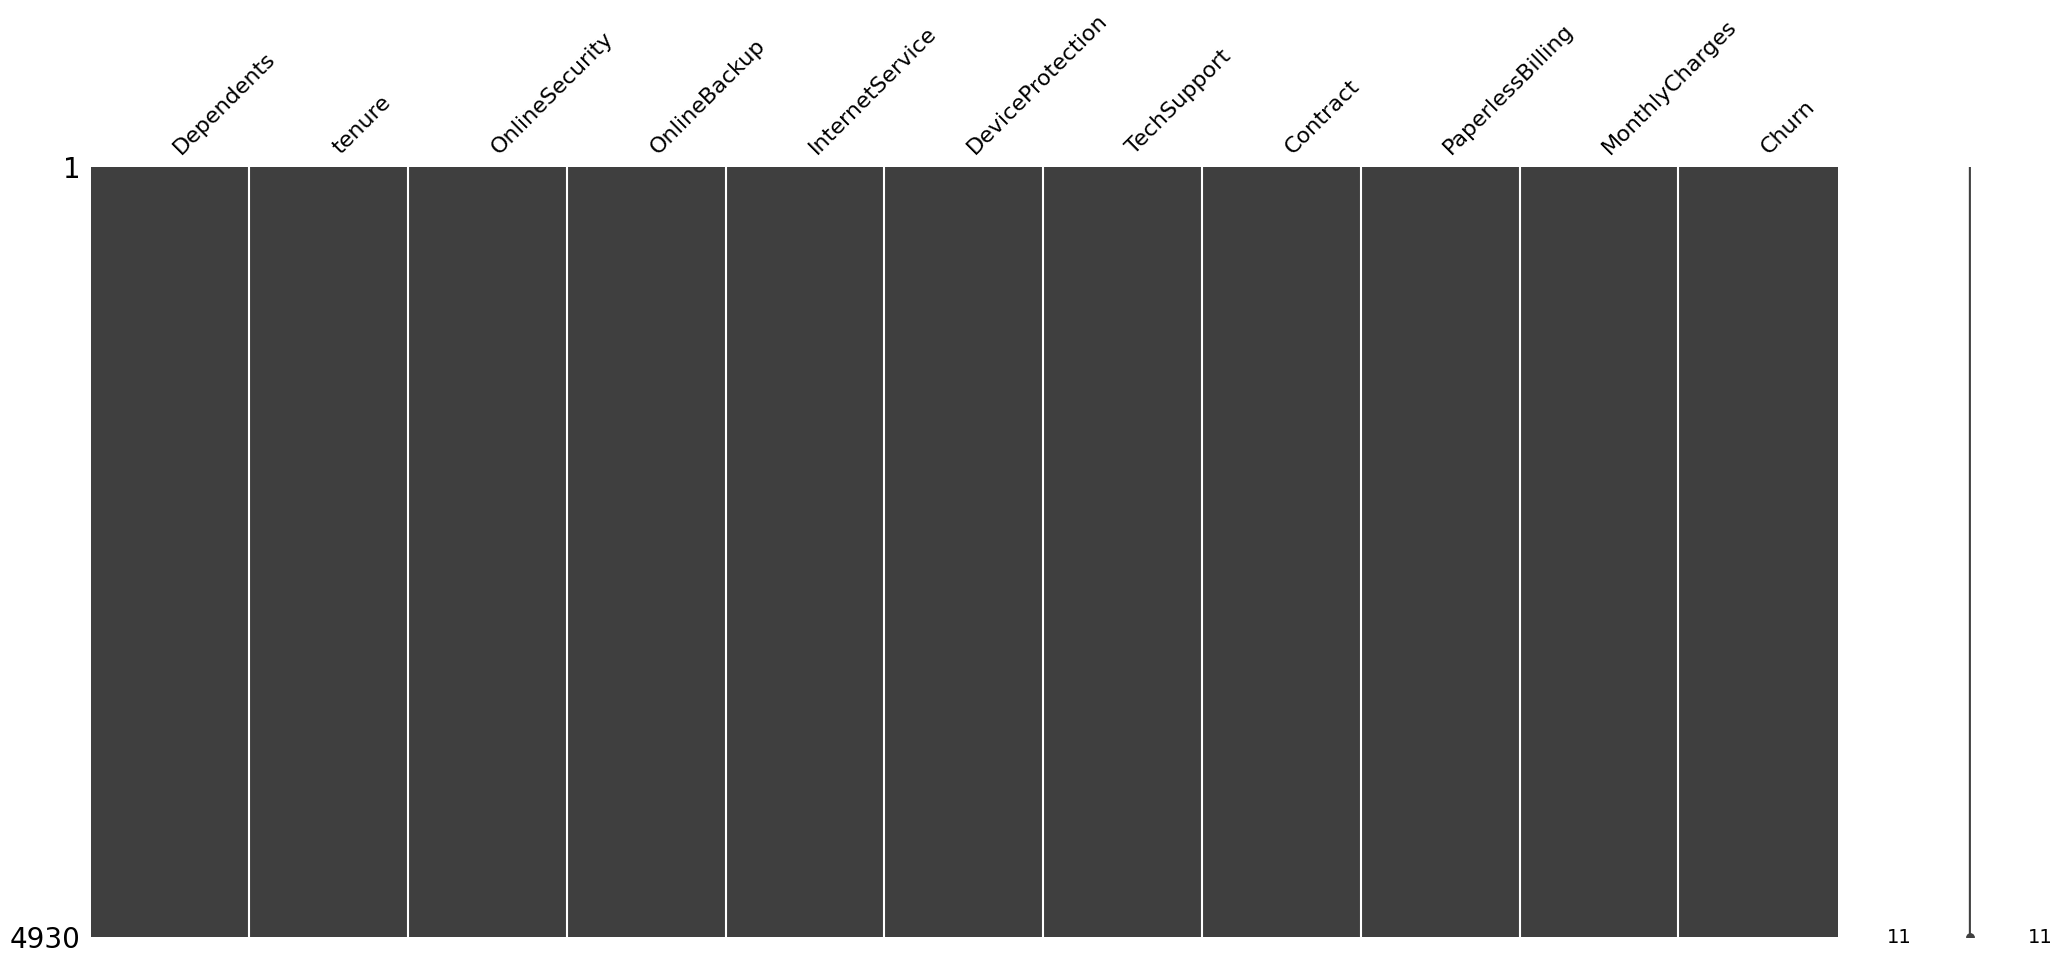

In [9]:
# Visualize missing values as a matrix
msno.matrix(df)

From the visualization above, there is no clearly distinct pattern observed, in fact there are also no missing values present.

In [10]:
df.groupby(['Contract','InternetService']).count()[['Churn']].loc['Month-to-month']

,Churn
InternetService,
DSL,848
Fiber optic,1511
No,362


In [11]:
df.groupby(['Contract','InternetService','Churn']).size()


Contract        InternetService  Churn
Month-to-month  DSL              No       572
                                 Yes      276
                Fiber optic      No       681
                                 Yes      830
                No               No       290
                                 Yes       72
One year        DSL              No       381
                                 Yes       33
                Fiber optic      No       302
                                 Yes       67
                No               No       263
                                 Yes        6
Two year        DSL              No       435
                                 Yes        9
                Fiber optic      No       273
                                 Yes       19
                No               No       417
                                 Yes        4
dtype: int64

**Conclusion from the data overview:**

* The dataset has no missing values.
* Most features are categorical, so encoding will be required before modeling.
* The variables *tenure* and *MonthlyCharges* may have non-normal distributions and potential outliers.
* The target variable *Churn* may have an imbalanced class distribution and needs further analysis during the EDA stage.

## EDA

In [12]:
# describe numerical features
df.describe()

,tenure,MonthlyCharges
count,4930.000000,4930.000000
mean,32.401217,64.883032
std,24.501193,29.923960
min,0.000000,18.800000
25%,9.000000,37.050000
50%,29.000000,70.350000
75%,55.000000,89.850000
max,72.000000,118.650000


In [13]:
# describe categorical features
df.describe(include='object')

,Dependents,OnlineSecurity,OnlineBackup,InternetService,DeviceProtection,TechSupport,Contract,PaperlessBilling,Churn
count,4930,4930,4930,4930,4930,4930,4930,4930,4930
unique,2,3,3,3,3,3,3,2,2
top,No,No,No,Fiber optic,No,No,Month-to-month,Yes,No
freq,3446,2445,2172,2172,2186,2467,2721,2957,3614


#### Categorical Analysis

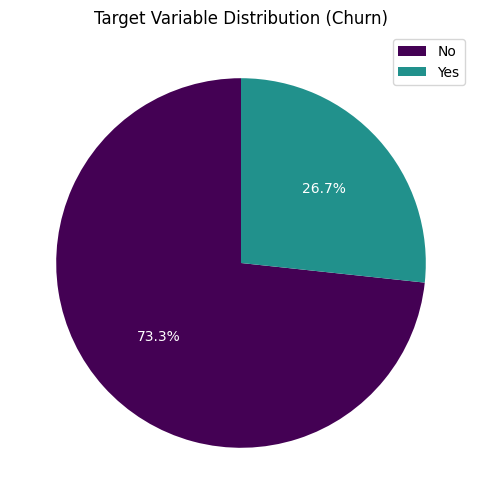

In [14]:
plt.figure(figsize=(6, 6))

churn_counts = df['Churn'].value_counts()

plt.pie(
    churn_counts,
    autopct='%1.1f%%',
    colors=['#440154', '#21918c'],
    startangle=90,
    textprops={'color': 'white'}
)

plt.legend(
    labels=churn_counts.index,
    loc='best'
)

plt.title('Target Variable Distribution (Churn)')
plt.show()


Based on the pie chart above, the target variable (Churn) is imbalanced, where the number of customers who did not churn is higher than those who churned.

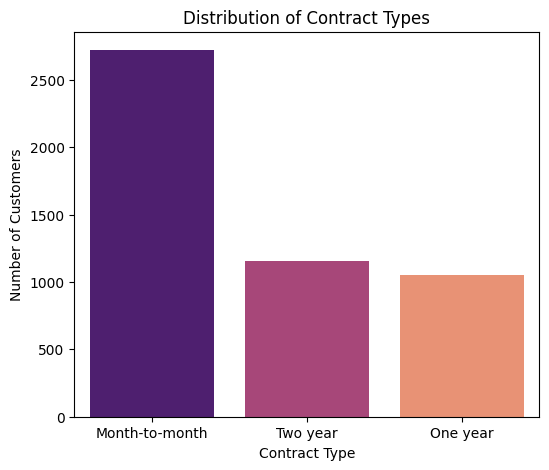

In [15]:
plt.figure(figsize=(6, 5))
sns.countplot(
    x='Contract',
    hue='Contract',
    data=df,
    palette='magma',
    legend=False
)
plt.xlabel('Contract Type')
plt.ylabel('Number of Customers')
plt.title('Distribution of Contract Types')
plt.show()


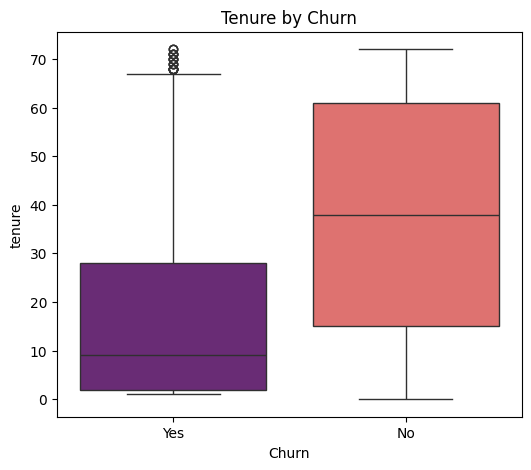

In [16]:
plt.figure(figsize=(6, 5))
sns.boxplot(x="Churn", y="tenure", palette='magma', data=df)
plt.title('Tenure by Churn')
plt.show()

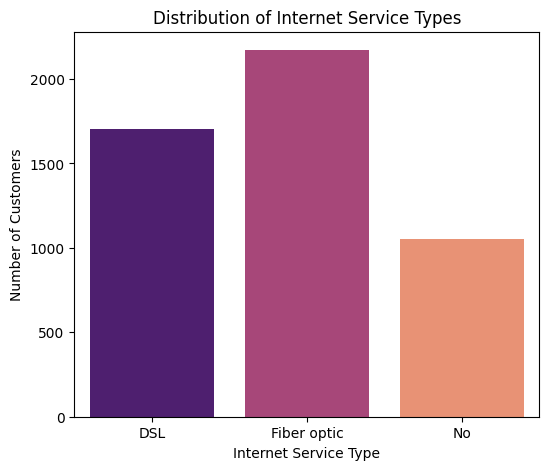

In [17]:
plt.figure(figsize=(6, 5))
sns.countplot(
    x='InternetService', 
    hue='InternetService',
    data=df,
    palette='magma',
    legend=False
    )
plt.xlabel('Internet Service Type') 
plt.ylabel('Number of Customers')
plt.title('Distribution of Internet Service Types')
plt.show()

The majority of customers subscribe to the Fiber Optic internet service.

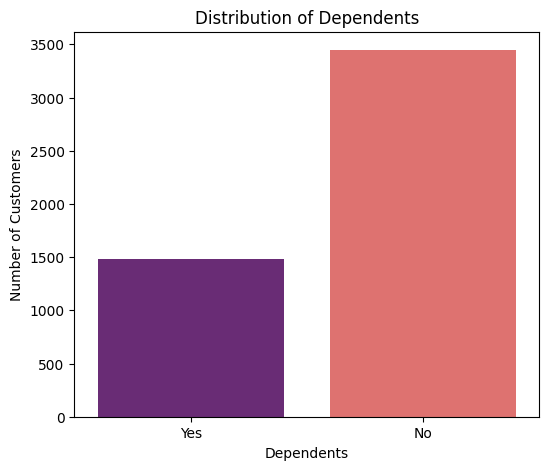

In [18]:
plt.figure(figsize=(6, 5))
sns.countplot(
    x='Dependents',
    hue='Dependents', 
    data=df,
    palette='magma',
    legend=False)
plt.xlabel('Dependents')
plt.ylabel('Number of Customers')
plt.title('Distribution of Dependents')
plt.show()

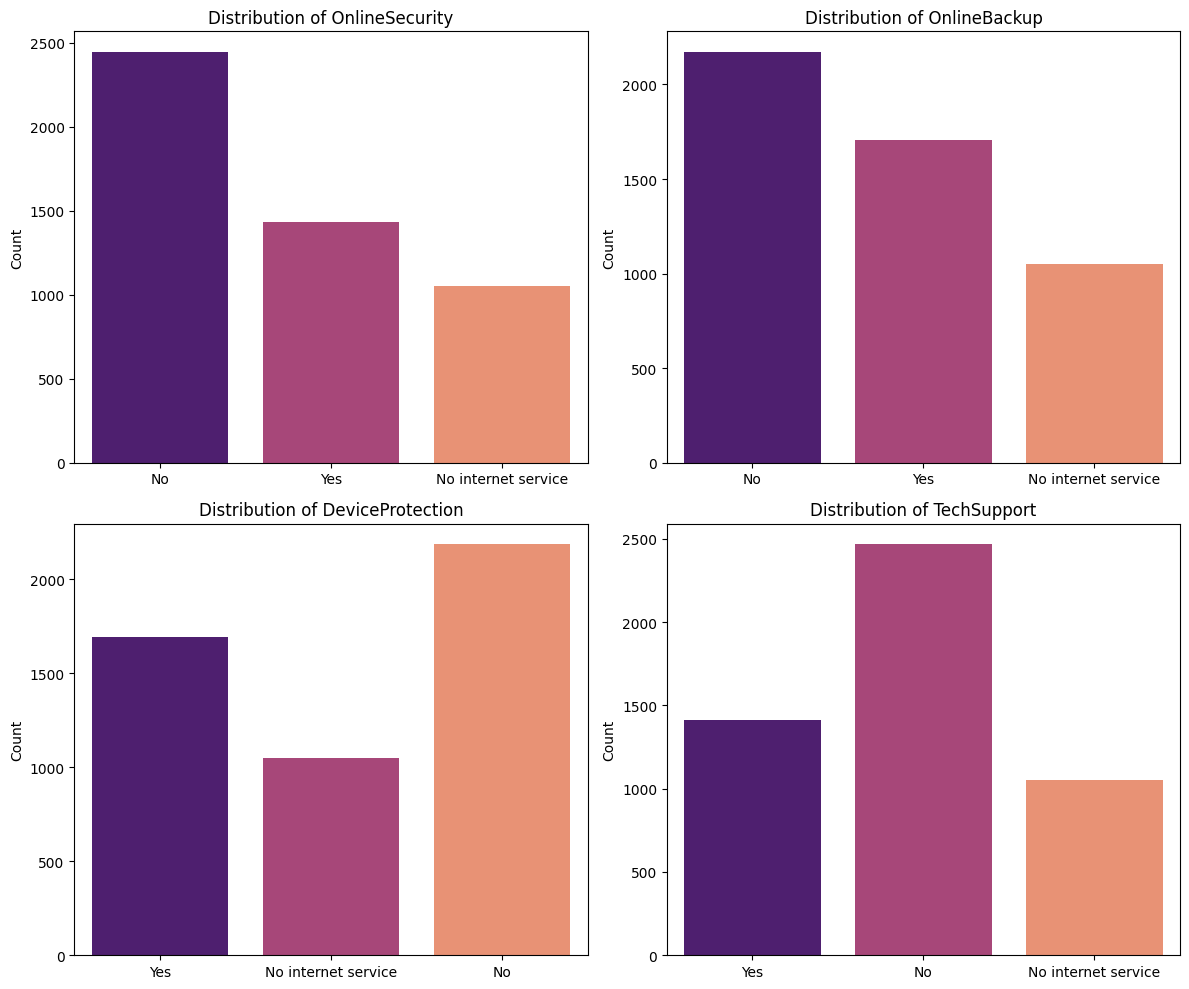

In [19]:
features = [
    'OnlineSecurity',
    'OnlineBackup',
    'DeviceProtection',
    'TechSupport'
]

fig, axes = plt.subplots(2, 2, figsize=(12, 10))
axes = axes.flatten()

for ax, col in zip(axes, features):
    sns.countplot(
        x=col,
        hue=col,
        data=df,
        palette='magma',
        legend=False,
        ax=ax
    )
    ax.set_title(f'Distribution of {col}')
    ax.set_xlabel('')
    ax.set_ylabel('Count')

plt.tight_layout()
plt.show()

#### Numerical Analysis

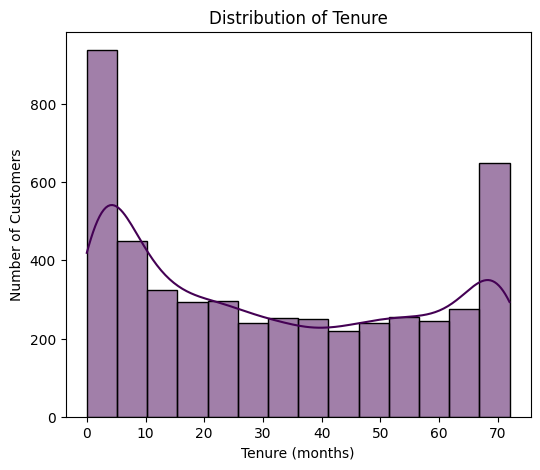

In [20]:
plt.figure(figsize=(6, 5))

sns.histplot(
    df['tenure'],
    kde=True,
    color='#440154'  # magma purple
)

plt.title('Distribution of Tenure')
plt.xlabel('Tenure (months)')
plt.ylabel('Number of Customers')
plt.show()


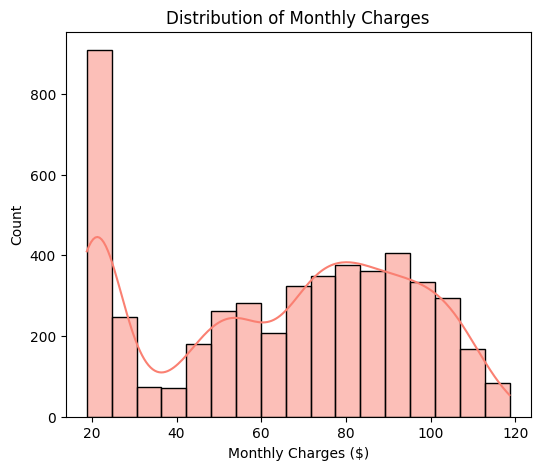

In [21]:
plt.figure(figsize=(6, 5))
sns.histplot(df['MonthlyCharges'], kde=True, color='salmon')
plt.title('Distribution of Monthly Charges')
plt.xlabel('Monthly Charges ($)')
plt.show()

#### Analisis Kategorikal vs Target (Churn)

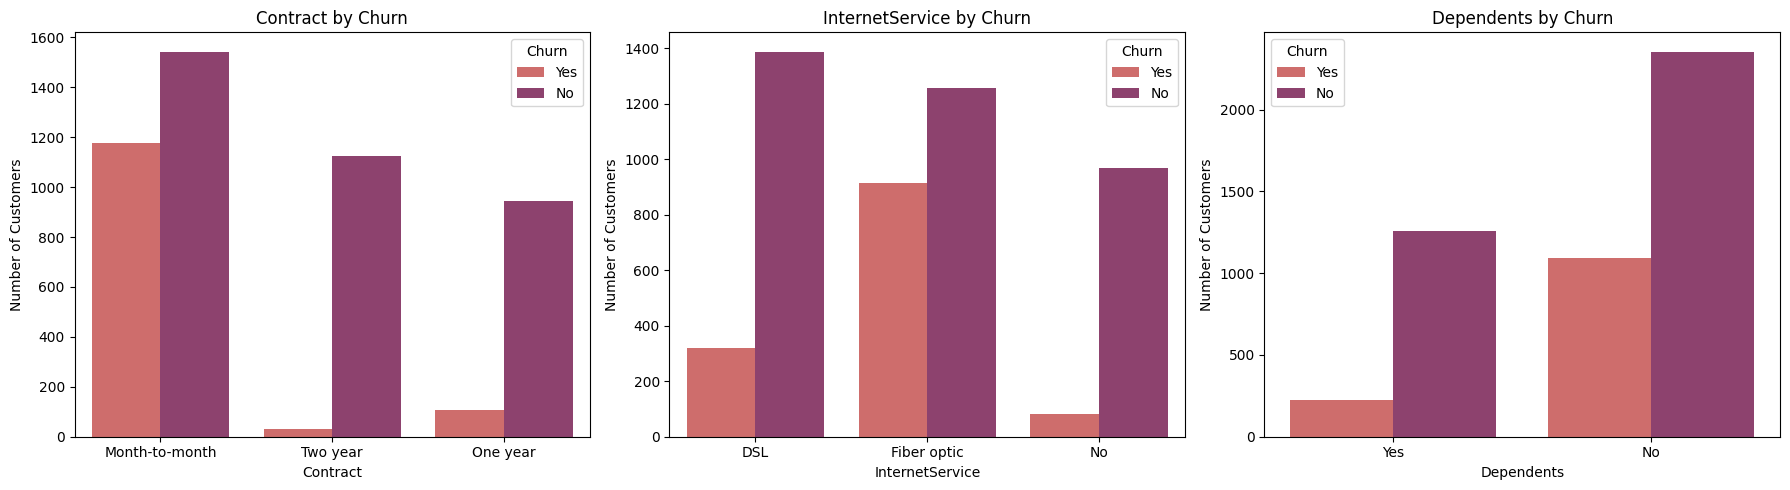

In [22]:
features = ['Contract', 'InternetService', 'Dependents']

fig, axes = plt.subplots(1, 3, figsize=(18, 5))

for ax, col in zip(axes, features):
    sns.countplot(
        x=col,
        hue='Churn',
        data=df,
        palette='flare',
        ax=ax
    )
    ax.set_title(f'{col} by Churn')
    ax.set_xlabel(col)
    ax.set_ylabel('Number of Customers')

plt.tight_layout()
plt.show()

- Customers with month-to-month contracts have a higher churn risk compared to those with longer contracts (one-year or two-year). This may be because newer customers are still trying the service and evaluating its quality and performance.

- Customers using Fiber Optic show the highest churn rate, while DSL users tend to stay longer. This may indicate a need to evaluate the quality and performance of the Fiber Optic service.

- Customers without dependents are more likely to churn than those with dependents, suggesting this group may need more focused retention efforts.


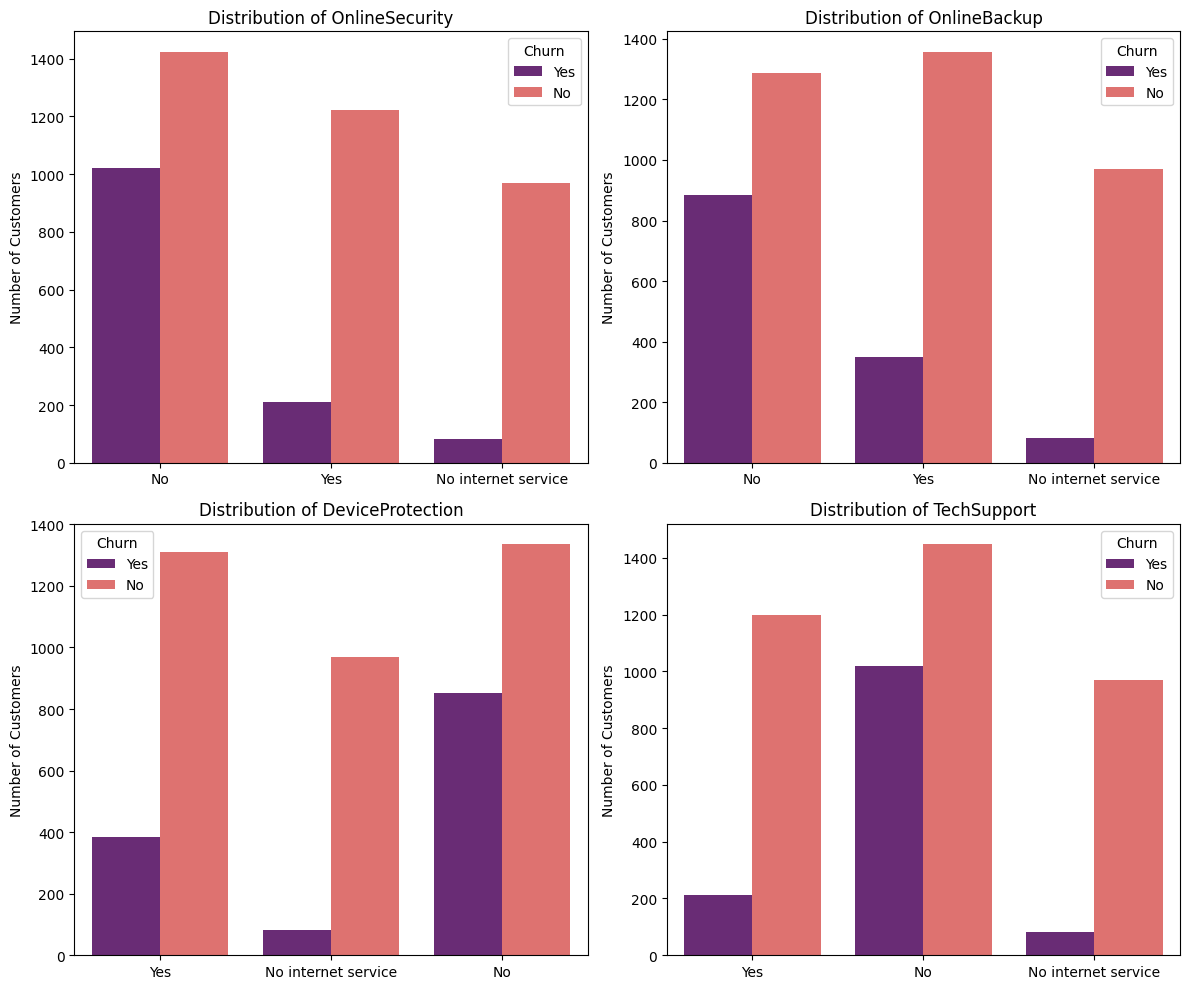

In [23]:
features = [
    'OnlineSecurity',
    'OnlineBackup',
    'DeviceProtection',
    'TechSupport'
]

fig, axes = plt.subplots(2, 2, figsize=(12, 10))
axes = axes.flatten()

for ax, col in zip(axes, features):
    sns.countplot(
        x=col,
        hue='Churn',
        data=df,
        palette='magma',
        ax=ax
    )
    ax.set_title(f'Distribution of {col}')
    ax.set_xlabel('')
    ax.set_ylabel('Number of Customers')

plt.tight_layout()
plt.show()

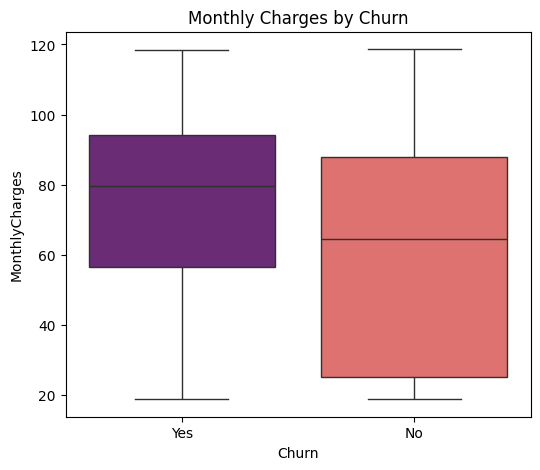

In [24]:
plt.figure(figsize=(6, 5))
sns.boxplot(x="Churn", y="MonthlyCharges", data=df, palette='magma')
plt.title('Monthly Charges by Churn')
plt.show()

Customers with higher monthly subscription fees tend to churn more compared to those with lower monthly costs.

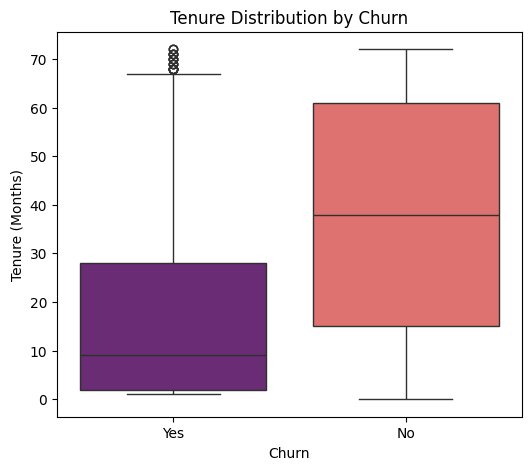

In [25]:
plt.figure(figsize=(6, 5))
sns.boxplot(x='Churn', y='tenure', data=df, palette='magma')
plt.title('Tenure Distribution by Churn')
plt.xlabel('Churn')
plt.ylabel('Tenure (Months)')
plt.show()

Customers who churn are mostly customer with shorter tenure compared to those who still subscribed. This indicates that newer customers are more likely to churn.

### Data Preparation

In [26]:
df.head()

,Dependents,tenure,OnlineSecurity,OnlineBackup,InternetService,DeviceProtection,TechSupport,Contract,PaperlessBilling,MonthlyCharges,Churn
0,Yes,9,No,No,DSL,Yes,Yes,Month-to-month,Yes,72.90,Yes
1,No,14,No,Yes,Fiber optic,Yes,No,Month-to-month,Yes,82.65,No
2,No,64,Yes,No,DSL,Yes,Yes,Two year,No,47.85,Yes
3,No,72,Yes,Yes,DSL,Yes,Yes,Two year,No,69.65,No
4,No,3,No internet service,No internet service,No,No internet service,No internet service,Month-to-month,Yes,23.60,No


Selanjutnya akan dilakuka proses scaling menggunakan Standard Scaler setelah itu akan dilakukan proses encoding untuk fitur-fitur kategorikal yang ada pada dataset Telco customer churn ini.

In [27]:
df.describe()

,tenure,MonthlyCharges
count,4930.000000,4930.000000
mean,32.401217,64.883032
std,24.501193,29.923960
min,0.000000,18.800000
25%,9.000000,37.050000
50%,29.000000,70.350000
75%,55.000000,89.850000
max,72.000000,118.650000


In [28]:
X = df.drop(columns=['Churn'])
y = df['Churn'].map({'No': 0, 'Yes': 1}).astype(int)

In [29]:
X_train, X_test, y_train, y_test = train_test_split(
    X, y,
    test_size=0.2,
    stratify=y,
    random_state=42
)

In [30]:
y_train.value_counts(normalize=True)
y_test.value_counts(normalize=True)


Churn
0    0.733266
1    0.266734
Name: proportion, dtype: float64

In [31]:
transformer = ColumnTransformer(
    transformers=[
        ('onehot', OneHotEncoder(handle_unknown='ignore'), [
            'OnlineSecurity', 'OnlineBackup', 'DeviceProtection',
            'TechSupport', 'InternetService', 'Contract'
        ]),
        ('binary', OrdinalEncoder(), ['Dependents', 'PaperlessBilling']),
        ('scaler', StandardScaler(), ['tenure', 'MonthlyCharges'])
    ],
    remainder='drop'
)

Setelah tahap EDA, dilakukan preprocessing data menggunakan ColumnTransformer untuk memastikan setiap fitur diproses sesuai dengan karakteristiknya. Fitur kategorikal nominal di-encode menggunakan One-Hot Encoding, fitur biner di-encode menggunakan Ordinal Encoding, dan fitur numerik dilakukan scaling menggunakan StandardScaler. Pendekatan ini bertujuan untuk mencegah data leakage dan memastikan kompatibilitas dengan berbagai model klasifikasi yang digunakan.

In [32]:
X_train, X_val, y_train, y_val = train_test_split(
    X_train, y_train,
    test_size=0.2,
    stratify=y_train,
    random_state=42
)

In [33]:
testing = pd.DataFrame(transformer.fit_transform(X_train),columns=transformer.get_feature_names_out())
testing.head()

,onehot__OnlineSecurity_No,onehot__OnlineSecurity_No internet service,onehot__OnlineSecurity_Yes,onehot__OnlineBackup_No,onehot__OnlineBackup_No internet service,onehot__OnlineBackup_Yes,onehot__DeviceProtection_No,onehot__DeviceProtection_No internet service,onehot__DeviceProtection_Yes,onehot__TechSupport_No,onehot__TechSupport_No internet service,onehot__TechSupport_Yes,onehot__InternetService_DSL,onehot__InternetService_Fiber optic,onehot__InternetService_No,onehot__Contract_Month-to-month,onehot__Contract_One year,onehot__Contract_Two year,binary__Dependents,binary__PaperlessBilling,scaler__tenure,scaler__MonthlyCharges
0,1.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0,1.0,0.0,0.0,0.0,1.0,-1.045744,0.334360
1,1.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,1.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,1.0,1.603626,1.337673
2,0.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,1.0,1.0,0.0,0.0,0.0,0.0,1.0,1.0,0.0,1.481348,-0.618954
3,0.0,0.0,1.0,0.0,0.0,1.0,1.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,-1.004984,-0.338959
4,1.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0,1.0,0.0,0.0,0.0,1.0,-1.290301,0.167697


In [34]:
from sklearn.pipeline import Pipeline
from sklearn.linear_model import LogisticRegression

baseline_model = Pipeline([
    ('preprocess', transformer),
    ('model', LogisticRegression(max_iter=1000))
])


Logistic Regression dipilih karena sesuai untuk klasifikasi biner, menghasilkan probabilitas yang dapat dioptimalkan threshold-nya, mudah diinterpretasikan, serta memberikan performa yang stabil dan kompetitif pada dataset churn.

In [35]:
baseline_model.fit(X_train, y_train)


,steps,"[('preprocess', ...), ('model', ...)]"
,transform_input,None
,memory,None
,verbose,False
,transformers,"[('onehot', ...), ('binary', ...), ...]"
,remainder,'drop'
,sparse_threshold,0.3
,n_jobs,None
,transformer_weights,None
,verbose,False
,verbose_feature_names_out,True


In [36]:
y_pred = baseline_model.predict(X_test)

print(classification_report(y_test, y_pred))
print(confusion_matrix(y_test, y_pred))


              precision    recall  f1-score   support

           0       0.84      0.88      0.86       723
           1       0.63      0.56      0.59       263

    accuracy                           0.79       986
   macro avg       0.74      0.72      0.73       986
weighted avg       0.79      0.79      0.79       986

[[637  86]
 [117 146]]


- 132 pelanggan yang churn gagal terdeteksi (FN)
- hanya 131 pelanggan yang churn yang terdeteksi dengan benar

#### Handling Class Imbalance on Baseline Model

In [37]:
balanced_model = Pipeline([
    ('preprocess', transformer),
    ('model', LogisticRegression(
        class_weight='balanced',
        max_iter=1000,
        random_state=42
    ))
])

balanced_model.fit(X_train, y_train)

,steps,"[('preprocess', ...), ('model', ...)]"
,transform_input,None
,memory,None
,verbose,False
,transformers,"[('onehot', ...), ('binary', ...), ...]"
,remainder,'drop'
,sparse_threshold,0.3
,n_jobs,None
,transformer_weights,None
,verbose,False
,verbose_feature_names_out,True


In [38]:
y_pred = balanced_model.predict(X_test)
print(classification_report(y_test, y_pred))
print(confusion_matrix(y_test, y_pred))

              precision    recall  f1-score   support

           0       0.92      0.73      0.82       723
           1       0.53      0.83      0.64       263

    accuracy                           0.76       986
   macro avg       0.72      0.78      0.73       986
weighted avg       0.82      0.76      0.77       986

[[529 194]
 [ 46 217]]


- True Positive (214): pelanggan churn yang berhasil teridentifikasi oleh model
- False Negative (49): pelanggan churn yang gagal terdeteksi oleh model
- False Positive (194): pelanggan yang diprediksi churn namun sebenarnya tidak
- True Negative (529): pelanggan non-churn yang terprediksi dengan benar

Dengan menggunakan class weighting, model menjadi lebih sensitif dalam mendeteksi pelanggan yang berpotensi churn. Meskipun jumlah pelanggan yang salah diprediksi churn meningkat, hal ini dapat diterima karena biaya yang timbul dari tindakan retensi masih lebih rendah dibandingkan kehilangan pelanggan yang sebenarnya churn.

In [39]:
skf = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)

cv_scores = cross_val_score(
    balanced_model,
    X_train,
    y_train,
    cv=skf,
    scoring='roc_auc'
)

print("ROC-AUC CV Mean:", cv_scores.mean())
print("ROC-AUC CV Std:", cv_scores.std())


ROC-AUC CV Mean: 0.8337082083613898
ROC-AUC CV Std: 0.01421370324910159


Berdasarkan hasil cross-validation, model Logistic Regression dengan class weighting memiliki performa yang baik dan stabil dan layak digunakan sebagai model prediksi churn dan dapat dijadikan baseline yang kuat sebelum melakukan pengembangan model lanjutan atau optimasi threshold.

#### Model Benchmarking

In [40]:
models = {
    'Logistic Regression': LogisticRegression(class_weight='balanced', max_iter=1000),
    'Random Forest': RandomForestClassifier(class_weight='balanced'),
    'XGBoost': XGBClassifier(eval_metric='logloss'),
    'LightGBM': lgb.LGBMClassifier()
}


In [41]:
skf = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)

results = []

for name, model in models.items():
    pipeline = Pipeline([
        ('preprocess', transformer),
        ('model', model)
    ])
    
    cv_scores = cross_val_score(
        pipeline,
        X_train,
        y_train,
        cv=skf,
        scoring='roc_auc'
    )
    
    results.append({
        'Model': name,
        'ROC-AUC Mean': cv_scores.mean(),
        'ROC-AUC Std': cv_scores.std()
    })

results_df = pd.DataFrame(results).sort_values(
    by='ROC-AUC Mean', ascending=False
)

results_df


[LightGBM] [Info] Number of positive: 674, number of negative: 1850
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.001892 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 369
[LightGBM] [Info] Number of data points in the train set: 2524, number of used features: 22
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.267036 -> initscore=-1.009711
[LightGBM] [Info] Start training from score -1.009711
[LightGBM] [Info] Number of positive: 674, number of negative: 1850
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000207 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 369
[LightGBM] [Info] Number of data points in the train set: 2524, number of used features: 22
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.267036 -> initscore=-1.009711
[LightGBM] [

,Model,ROC-AUC Mean,ROC-AUC Std
0,Logistic Regression,0.833708,0.014214
3,LightGBM,0.815376,0.015072
2,XGBoost,0.802234,0.021506
1,Random Forest,0.794502,0.021486


Berdasarkan hasil model benchmarking menggunakan ROC-AUC cross-validation, Logistic Regression dengan penanganan ketidakseimbangan kelas (class weighting) menunjukkan nilai ROC-AUC rata-rata tertinggi (0.834) serta variabilitas performa yang relatif rendah dibandingkan model lain.

Meskipun model berbasis tree seperti LightGBM dan XGBoost juga menunjukkan performa yang kompetitif, Logistic Regression dipilih sebagai model akhir karena menawarkan keseimbangan antara performa, stabilitas, dan interpretabilitas yang penting untuk memahami faktor-faktor utama yang memengaruhi churn pelanggan.

#### Final Model Selection

In [42]:
final_model = Pipeline([
    ('preprocess', transformer),
    ('model', LogisticRegression(
        class_weight='balanced',
        max_iter=1000,
        random_state=42
    ))
])


#### Hyperparameter Tuning 

In [43]:
param_grid = {
    'model__C': [0.01, 0.1, 1, 10],
    'model__penalty': ['l1', 'l2'],
    'model__solver': ['liblinear']
}


In [44]:
skf = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)

grid = GridSearchCV(
    estimator=final_model,
    param_grid=param_grid,
    scoring='roc_auc',
    cv=skf,
    n_jobs=-1
)

grid.fit(X_train, y_train)


,estimator,Pipeline(step...m_state=42))])
,param_grid,"{'model__C': [0.01, 0.1, ...], 'model__penalty': ['l1', 'l2'], 'model__solver': ['liblinear']}"
,scoring,'roc_auc'
,n_jobs,-1
,refit,True
,cv,StratifiedKFo... shuffle=True)
,verbose,0
,pre_dispatch,'2*n_jobs'
,error_score,nan
,return_train_score,False
,transformers,"[('onehot', ...), ('binary', ...), ...]"


GridSearchCV digunakan untuk memperoleh kombinasi hyperparameter terbaik secara objektif dengan evaluasi cross-validation untuk memastikan model memiliki performa optimal dan generalisasi yang baik pada kasus churn dengan data imbalance dimana pemilihan parameter yang tepat sangat berpengaruh terhadap ROC-AUC.

In [45]:
final_model_tuned = grid.best_estimator_

print("Best ROC-AUC (CV):", grid.best_score_)
print("Best parameters:", grid.best_params_)


Best ROC-AUC (CV): 0.8342601125683864
Best parameters: {'model__C': 0.01, 'model__penalty': 'l2', 'model__solver': 'liblinear'}


In [46]:

y_pred_tuned = final_model_tuned.predict(X_test)
y_proba_tuned = final_model_tuned.predict_proba(X_test)[:, 1]

print("Tuned model ROC-AUC:", roc_auc_score(y_test, y_proba_tuned))


Tuned model ROC-AUC: 0.8550031817153917


In [47]:
final_model.fit(X_train, y_train)  # Fit default (untuned) model
y_proba_default = final_model.predict_proba(X_test)[:, 1]  # Get probabilities

#### Mencari Threshold Terbaik

In [48]:
y_val_prob = final_model_tuned.predict_proba(X_val)[:, 1]

thresholds = [i/100 for i in range(20, 61)]
best_f1 = 0
best_threshold = 0

for th in thresholds:
    y_val_pred = (y_val_prob >= th).astype(int)
    f1 = f1_score(y_val, y_val_pred)

    if f1 > best_f1:
        best_f1 = f1
        best_threshold = th

print("Best Threshold:", best_threshold)
print("Best Validation F1:", best_f1)


Best Threshold: 0.51
Best Validation F1: 0.6543438077634011


In [49]:
# Default 0.5
y_val_pred_05 = (y_val_prob >= 0.5).astype(int)

# Optimized threshold
y_val_pred_opt = (y_val_prob >= best_threshold).astype(int)

print("Default Threshold (0.5)")
print(confusion_matrix(y_val, y_val_pred_05))

print("Optimized Threshold")
print(confusion_matrix(y_val, y_val_pred_opt))


Default Threshold (0.5)
[[417 161]
 [ 33 178]]
Optimized Threshold
[[425 153]
 [ 34 177]]


#### Perbandingan Performa Model dengan Threshold Default dan Threshold Optimal

In [50]:

# --- 1. Tuned model with optimized threshold ---
y_test_prob_tuned = final_model_tuned.predict_proba(X_test)[:, 1]
y_test_pred_tuned = (y_test_prob_tuned >= best_threshold).astype(int)

print(classification_report(y_test, y_test_pred_tuned))
print(confusion_matrix(y_test, y_test_pred_tuned))
print("ROC-AUC:", roc_auc_score(y_test, y_test_prob_tuned))

# --- 2. Default model with standard threshold 0.5 ---
y_test_prob_default = final_model.predict_proba(X_test)[:, 1]
y_test_pred_default = (y_test_prob_default >= 0.5).astype(int)

print(classification_report(y_test, y_test_pred_default))
print(confusion_matrix(y_test, y_test_pred_default))
print("ROC-AUC:", roc_auc_score(y_test, y_test_prob_default))


              precision    recall  f1-score   support

           0       0.92      0.73      0.81       723
           1       0.53      0.82      0.64       263

    accuracy                           0.75       986
   macro avg       0.72      0.78      0.73       986
weighted avg       0.81      0.75      0.77       986

[[528 195]
 [ 47 216]]
ROC-AUC: 0.8550031817153917
              precision    recall  f1-score   support

           0       0.92      0.73      0.82       723
           1       0.53      0.83      0.64       263

    accuracy                           0.76       986
   macro avg       0.72      0.78      0.73       986
weighted avg       0.82      0.76      0.77       986

[[529 194]
 [ 46 217]]
ROC-AUC: 0.855118880456905


Model menunjukkan performa yang baik dalam mendeteksi pelanggan churn dengan ROC-AUC sebesar 0.855 dan recall churn di atas 80%. Perbedaan metrik antara model tuned dan default sangat kecil dan tidak signifikan secara praktis, sehingga model hasil hyperparameter tuning tetap dipilih karena lebih robust dan dapat dipertanggungjawabkan.

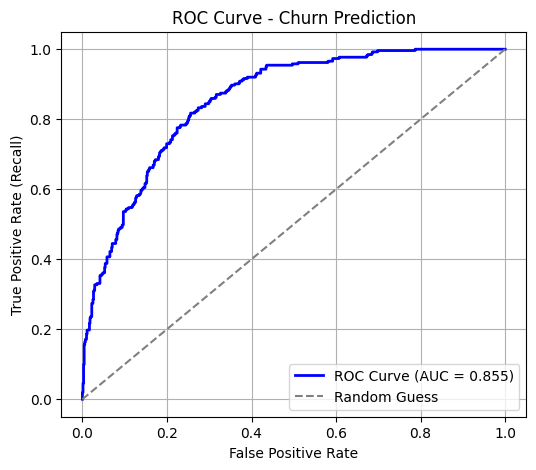

In [51]:
from sklearn.metrics import roc_curve, auc
import matplotlib.pyplot as plt

# probabilitas prediksi kelas 1 (churn)
y_test_prob = final_model_tuned.predict_proba(X_test)[:, 1]

# hitung ROC
fpr, tpr, thresholds = roc_curve(y_test, y_test_prob)
roc_auc = auc(fpr, tpr)

# plot ROC Curve
plt.figure(figsize=(6,5))
plt.plot(fpr, tpr, color='blue', lw=2, label=f'ROC Curve (AUC = {roc_auc:.3f})')
plt.plot([0, 1], [0, 1], color='gray', linestyle='--', label='Random Guess')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate (Recall)')
plt.title('ROC Curve - Churn Prediction')
plt.legend(loc='lower right')
plt.grid(True)
plt.show()


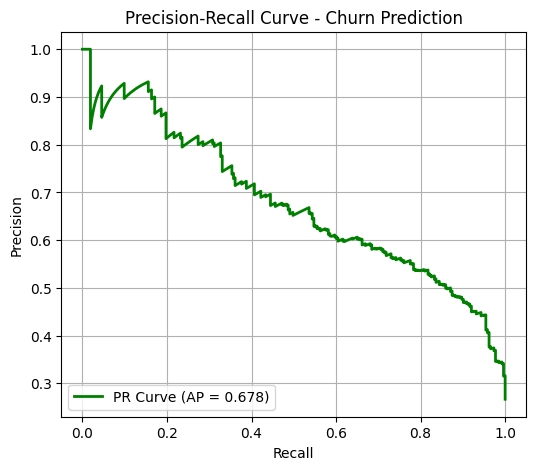

In [52]:
from sklearn.metrics import precision_recall_curve, average_precision_score

# hitung precision, recall
precision, recall, thresholds_pr = precision_recall_curve(y_test, y_test_prob)
avg_precision = average_precision_score(y_test, y_test_prob)

# plot PR Curve
plt.figure(figsize=(6,5))
plt.plot(recall, precision, color='green', lw=2, label=f'PR Curve (AP = {avg_precision:.3f})')
plt.xlabel('Recall')
plt.ylabel('Precision')
plt.title('Precision-Recall Curve - Churn Prediction')
plt.grid(True)
plt.legend(loc='lower left')
plt.show()


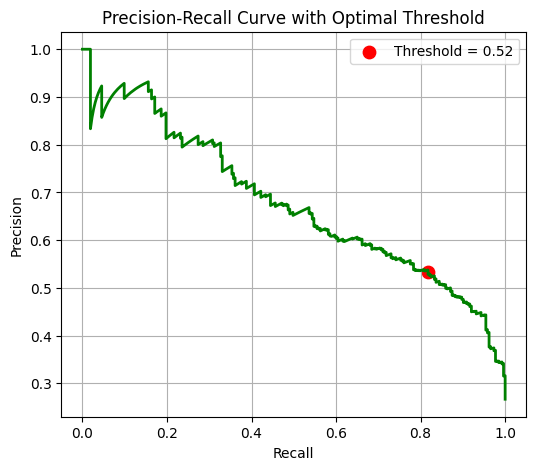

In [53]:
import numpy as np

# cari index threshold paling dekat dengan best_threshold
best_threshold = 0.52
best_idx = np.argmin(np.abs(thresholds_pr - best_threshold))

plt.figure(figsize=(6,5))
plt.plot(recall, precision, color='green', lw=2)
plt.scatter(recall[best_idx], precision[best_idx], color='red', s=80, label=f'Threshold = {best_threshold}')
plt.xlabel('Recall')
plt.ylabel('Precision')
plt.title('Precision-Recall Curve with Optimal Threshold')
plt.legend()
plt.grid(True)
plt.show()


In [54]:
import numpy as np
import pandas as pd

# ambil model logreg dari pipeline
logreg = final_model_tuned.named_steps['model']

# ambil feature names setelah preprocessing
feature_names = final_model_tuned.named_steps['preprocess'].get_feature_names_out()

# ambil koefisien
coef = logreg.coef_[0]

# buat dataframe
importance_df = pd.DataFrame({
    'Feature': feature_names,
    'Coefficient': coef,
    'Odds_Ratio': np.exp(coef)
})

# urutkan berdasarkan pengaruh terbesar
importance_df = importance_df.sort_values(
    by='Odds_Ratio',
    ascending=False
)

importance_df.head(10)


,Feature,Coefficient,Odds_Ratio
15,onehot__Contract_Month-to-month,0.343241,1.409509
21,scaler__MonthlyCharges,0.321154,1.378718
19,binary__PaperlessBilling,0.190163,1.209447
0,onehot__OnlineSecurity_No,0.179184,1.196241
13,onehot__InternetService_Fiber optic,0.178633,1.195582
9,onehot__TechSupport_No,0.137192,1.147048
3,onehot__OnlineBackup_No,0.100893,1.106158
6,onehot__DeviceProtection_No,-0.018663,0.981510
8,onehot__DeviceProtection_Yes,-0.068958,0.933366
1,onehot__OnlineSecurity_No internet service,-0.147934,0.862488


Hasil feature importance menunjukkan bahwa kontrak bulanan, biaya bulanan yang tinggi, serta tidak adanya layanan tambahan seperti Online Security dan Tech Support merupakan faktor utama yang meningkatkan risiko churn. Fitur dengan koefisien bernilai positif dan odds ratio (OR) lebih besar dari 1 menunjukkan bahwa fitur tersebut meningkatkan peluang pelanggan untuk churn, sedangkan koefisien negatif dan OR < 1 menandakan penurunan risiko churn. Sebaliknya, pelanggan yang menggunakan layanan proteksi perangkat memiliki OR < 1 sehingga cenderung lebih loyal. Temuan ini mengindikasikan bahwa churn sangat dipengaruhi oleh persepsi nilai layanan terhadap harga, sehingga strategi retensi sebaiknya difokuskan pada pelanggan kontrak bulanan dengan biaya tinggi melalui peningkatan layanan atau penawaran paket yang lebih kompetitif.

# Recommendation
- Memprioritaskan program retensi untuk pelanggan kontrak month-to-month, karena segmen ini memiliki risiko churn paling tinggi.
- Memberikan insentif upgrade ke kontrak jangka panjang untuk menurunkan probabilitas churn dan meningkatkan retensi.
- Menargetkan pelanggan dengan biaya bulanan tinggi melalui penawaran harga atau program loyalitas yang lebih personal.
- Menyediakan bundling layanan keamanan dan dukungan teknis untuk meningkatkan keterikatan pelanggan dan mengurangi risiko churn.

#### Save Model ke Pickle

In [55]:
import pickle

estimator = {
    "model": final_model_tuned,
    "best_threshold": best_threshold
}

with open("telco_churn_model.pkl", "wb") as f:
    pickle.dump(estimator, f)


#### Load Model

In [56]:
# telco_churn_model = pickle.load(open('telco_churn_model.pkl', 'rb'))

# model = telco_churn_model["model"]
# threshold = telco_churn_model["best_threshold"]